In [44]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import h5py
from tqdm import tqdm
from BCE_diceloss import BCEDiceLoss
from pixel_patch_dataset import PixelPatchDataset
import cnn_extractor_ideal as cnn

# Choose Slice to Visualize
#### If you can read this, shout out a number between 8 and 50




............................................................................................................................................................................................................

............................................................................................................................................................................................................

# Just Kidding!!!!

In [2]:
demo_slice = 27

In [3]:
# Initialize the dataset
dataset = PixelPatchDataset(
    scan_path='../data/scans.h5',
    mask_path='../data/masks.h5',
    meta_path='../data/slice_info.h5',
    patch_size=9,
    stride=1
)

Loading Data: 100%|██████████| 2560/2560 [00:38<00:00, 67.29it/s] 


In [4]:
# find coords in slice
indices = dataset.pixel_coords[dataset.pixel_coords[:, 3] == demo_slice]
idxs = indices[:, 0].squeeze()
image_subset =  torch.utils.data.Subset(dataset, idxs)
print(len(idxs))


16384


# Say WHAAAAA!!!! Why are there so many values?!?!?!?!

Because we have to do pixel-wise image segmentation.... and the images are 128px by 128px

In [5]:
with h5py.File(dataset.scan_path, 'r') as f_scan:
    scan_slice = f_scan['scans/data'][
        dataset.center - dataset.cropsize // 2:dataset.center + dataset.cropsize // 2,
        dataset.center - dataset.cropsize // 2:dataset.center + dataset.cropsize // 2,
        demo_slice
        ]

In [40]:
# Setup model
from BCE_diceloss import BCEDiceLoss
cnn_model = cnn.CNNFeatureExtractor()
input_size = 8 * (dataset.patch_size // 8)**2 + 3  # features + position
output_size = 3
log_model = torch.nn.Sequential(
    torch.nn.Linear(in_features=input_size, out_features=output_size),
    torch.nn.Sigmoid()
)

# Load trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_loader = torch.utils.data.DataLoader(image_subset, batch_size = 256, shuffle=False, num_workers=8)
log_model.load_state_dict(torch.load("../data/checkpoint_3.pth", map_location=device)['model_state_dict'])
log_model.to(device)
log_model.eval()
cnn_model.to(device)
cnn_model.eval()

# Criterion
criterion = BCEDiceLoss()

y_preds = []
slice_losses = []
slice_dices = []
with torch.no_grad():
    for batch_i, batch in enumerate(tqdm(image_loader, desc="Image Predicting")):
        pix_patch = batch['patch'].to(device)
        positions = batch['position'].to(device)
        y_true = batch['label'].to(device).long()
        y_true_onehot = torch.nn.functional.one_hot(y_true, num_classes=3).float()
        
        # extract features
        features = cnn_model(pix_patch)
        features = features.view(features.size(0), -1)
        combined = torch.cat((features, positions), dim=1)
        
        # make predictions and evaluate
        y_pred = log_model(combined)
        loss, dice = criterion(y_pred, y_true_onehot)

        slice_losses.append(loss.item())
        slice_dices.append(dice.item())

        # get classes
        preds = torch.argmax(y_pred, dim=1).cpu().numpy()
        y_preds.extend(preds)


/tmp/ipykernel_6524/3546368137.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  log_model.load_state_dict(torch.load("../data/checkpoint_3.pth", map_location=device)['mo

Image Predicting: 100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


# Take a Guess at how well it will make predictions!!!

Whatever you think it is... your wrong!

It should be predicting 3 classes:
- 0: Not Cartilage
- 1: Femoral Cartilage
- 2: Tibial Cartilage

In [13]:
print(np.unique(y_preds))

[0]


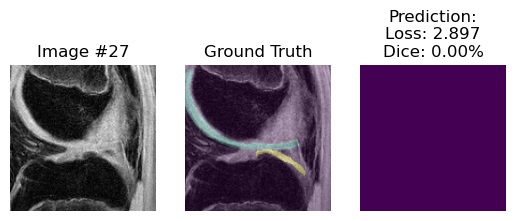

In [42]:
mask = np.zeros((128, 128)).flatten()
mask = indices[:, 4].reshape((128,128))

y_preds = np.array(y_preds).reshape(128, 128)

# show scan as image
plt.figure(1, clear=True)
plt.subplot(131)
plt.imshow(scan_slice, cmap="grey")
plt.title(f"Image #{demo_slice}")
plt.axis("off")

plt.subplot(132)
plt.imshow(scan_slice[5:133, 5:133], 
        cmap="grey")
plt.imshow(mask, cmap="viridis", alpha=0.3)
plt.axis("off")
plt.title("Ground Truth")

plt.subplot(133)
plt.imshow(y_preds)
if np.unique(y_preds) == 0:
    slice_dices = np.array([0])
plt.title(f"Prediction:\nLoss: {np.mean(slice_losses):.3f}\nDice: {np.mean(slice_dices)*100:.2f}%")
plt.axis("off")
plt.show()

# Now... you might ask:
Guys, what about other slices? Surely this is not the case for all of the model!

And to that I would say... **your wrong**. My implementation of this logistic regression model was wrong and I realized too late.
- One epoch = 2-4 days
- I have been slowly crushed by PyTorch Dataset and Dataloader classes


In [43]:
linear_layer = log_model[0]
weights = linear_layer.weight.data.cpu().numpy()  # shape: (output_size, input_size)
biases = linear_layer.bias.data.cpu().numpy()     # shape: (output_size,)

for i, class_weights in enumerate(weights):
    print(f"Class {i} weights:")
    print(class_weights)
    print(f"Bias: {biases[i]}")
    print()

Class 0 weights:
[ 1.8626312   2.0331743   2.5749629   2.437059    2.1169271   2.351925
  2.1306262   2.5573187   0.26665404  0.37191802 -0.02530394]
Bias: -4.2813544273376465

Class 1 weights:
[-1.5796559  -1.1575713  -1.3614781  -1.5393914  -1.302224   -1.2046168
 -1.0588349  -1.4084784  -0.22836012 -0.7403483  -0.30415586]
Bias: -1.4890034198760986

Class 2 weights:
[ 0.1648642  -0.29109508  0.02174846  0.2975007   0.10092561 -0.15878181
 -0.17733799 -0.10627428 -1.9158442  -3.0134313  -2.6958005 ]
Bias: -3.9315192699432373



In [31]:
linear_layer = log_model[0]
weights = linear_layer.weight.data.cpu().numpy()  # shape: (output_size, input_size)
biases = linear_layer.bias.data.cpu().numpy()     # shape: (output_size,)

for i, class_weights in enumerate(weights):
    print(f"Class {i} weights:")
    print(class_weights)
    print(f"Bias: {biases[i]}")
    print()

Class 0 weights:
[-0.04263048 -0.18841745  0.35344452  0.21444719  0.35688713  0.12942012
  0.35380226  0.33599073  0.08548032  0.44223592  0.46079475]
Bias: 0.3892558813095093

Class 1 weights:
[-0.30883303  0.1131108  -0.09105112 -0.26864803 -0.34898132  0.06630044
 -0.10551306 -0.13810033 -0.20724118 -0.35203236 -0.47331783]
Bias: -0.8822991847991943

Class 2 weights:
[ 0.1648642  -0.29109508  0.02174846  0.2975007   0.10092561 -0.15878181
 -0.17733799 -0.10627428 -0.6143509  -0.6705006  -0.3379819 ]
Bias: -1.6381916999816895

